## Generating molecules with a trained autoencoder

In [1]:
import numpy as np
import h5py    
import json
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from molecules.model import MoleculeVAE
from molecules.utils import one_hot_array, one_hot_index, from_one_hot_array, decode_smiles_from_indexes, load_dataset, encode_smiles, decode_latent_molecule, interpolate, get_unique_mols

# number of dimensions to represent the molecules
# as the model was trained with this number, any operation made with the model must share the dimensions.
LATENT_DIM = 292

# trained_model 0.99 validation accuracy
# trained with 80% of ALL chembl molecules, validated on the other 20.
trained_model = 'model.h5'
charset_file = 'charset.json'

Using TensorFlow backend.


In [2]:
data_train, data_test, charset = load_dataset('data/processed.h5')

In [3]:
# load charset and model
with open('charset.json', 'r') as outfile:
    charsets = json.load(outfile)

### Load a model

In [4]:
model = MoleculeVAE()
model.load(charset, trained_model, latent_rep_size = LATENT_DIM)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


### Encode one SMILES  example into it's latent representation

In [5]:
smiles_1 = 'Cc1ccc2[nH]c3nc4ccccc4c3c(C)c2c1'

In [6]:
smiles_1_latent = encode_smiles(smiles_1, model, charsets)
smiles_1_latent
print('{:20s} : {} with norm {:.3f}'.format('latent representation',smiles_1_latent.shape, np.linalg.norm(smiles_1_latent)))

latent representation : (1, 292) with norm 1.463


### Check: Are we reconstructing our SMILES example properly?

In [7]:
reconstructed_smiles_1 = decode_latent_molecule(smiles_1_latent, model, charsets, LATENT_DIM)
original = Chem.MolFromSmiles(smiles_1)
reconstructued_1 = Chem.MolFromSmiles(reconstructed_smiles_1)
print('{:20s} : {}'.format('Input:',smiles_1))
print('{:20s} : {}'.format('Reconstructued:', reconstructed_smiles_1))

Input:               : Cc1ccc2[nH]c3nc4ccccc4c3c(C)c2c1
Reconstructued:      : Cc1ccc2[nH]c3cc4ccccc4c3c(C)c2c1


### Decode the randomly SMILES example centered generated latent representations
* Generating 1k random 292 dimension continuous arrays with mean = smiles_1_latent and stdev==0.1 to sample the latent space next to the SMILES example
* Decode into molecules!

In [8]:
# Looking for 1k neighbours
stdev = 0.1
latent_mols = stdev * np.random.randn(1000, LATENT_DIM) + smiles_1_latent

In [9]:
decoded_molecules = []
for lm in latent_mols:
    decoded_molecules.append(decode_latent_molecule(lm, model, charsets, LATENT_DIM))

### Validate the molecules using RDKit

In [10]:
from rdkit import Chem
from rdkit import RDLogger

# remove warnings and errors from notebook (lots of them due non valid molecule generation)
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

working_mols = []
for smiles in decoded_molecules:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue

### Visualise the artificially generated molecules

* original molecules 

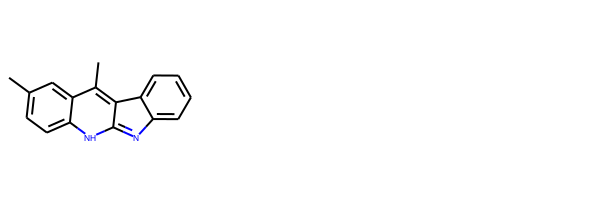

In [13]:
Draw.MolsToGridImage([original])

* generated molecules

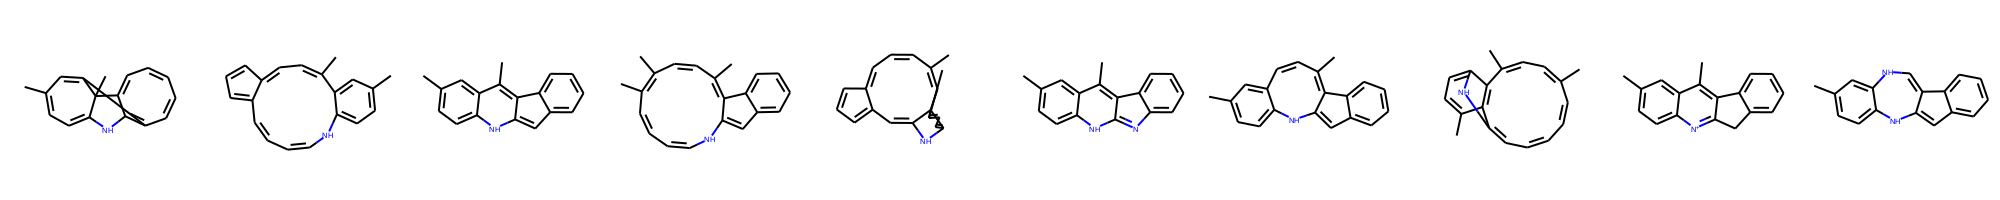

In [11]:
Draw.MolsToGridImage([mol for mol in working_mols], molsPerRow=10)